# Takeaways
- Maintain separate payloads for api vs. mobile
    - Faster to read/write .parquet + .npy, but only api can use those
    - Mobile needs to use .sqlite + files (.png, .mp4), but it's slower for both read and write
- TODO Still more room to compress mobile payloads
    - 71% of payload: audio
        - Can be cut in ~half if we can drop 32k -> 16k (maybe with aac_he?)
            - Android supports HE-AACv2: https://developer.android.com/guide/topics/media/media-formats
            - But ios doesn't? https://apple.co/2NORQHB
        - Payload 1.98g -> ~1.28g -- ✅ ~35% of payload
    - 21% of payload: spectro
        - Not much excess: maybe ~5% of spectros (see notebooks/spectro_img_encode)
        - Payload 1.98g -> ~1.96g -- ❌ ~1% of payload
    - 5.9% of payload: f_preds_* sqlite cols (n_sp=331)
        - (Based on: 119m = 164m with - 45m without)
        - No float32 in sqlite, only float64 [❓ Unless we get clever and pack into int32/int16, or blob...]
            - [e.g. blob: https://github.com/SeanTater/sqlite3-extras]
        - Can pca compress, but can't achieve more than a few % of payload
        - Payload 1.98g -> ~1.98g with n_components=331 -- min ~0% of payload
        - Payload 1.98g -> ~1.93g with n_components=150 --  🔶 ~3% of payload
        - Payload 1.98g -> ~1.90g with n_components=100 --  🔶 ~4% of payload
        - Payload 1.98g -> ~1.86g with n_components=10  --  🔶 ~6% of payload
        - Payload 1.98g -> ~1.86g with n_components=0   -- max ~6% of payload
    - 2.2% of payload: rest of sqlite cols
        - Max ~2% of payload -- ❌ low ROI

In [ ]:
from notebooks import *
sg.init(None, skip=[sg_load.load_search_recs])
get_search_recs.cache_clear()

INFO     [10:43:53.016] [19766] 150 logging_/<module>: {logging_yaml: None}

INFO     [10:43:53.498] [19766]  32 api.server_globals/init

DEBUG    [10:43:53.505] [19766]  75 api.server_globals/load: load_search...

INFO     [10:43:54.007] [19766]  79 api.server_globals/load: load_search (took 0.494s)

DEBUG    [10:43:54.014] [19766]  75 api.server_globals/load: load_xc_meta...

INFO     [10:43:54.365] [19766]  79 api.server_globals/load: load_xc_meta (took 0.345s)

DEBUG    [10:43:54.372] [19766]  75 api.server_globals/load: load_feat_info...

INFO     [10:43:54.379] [19766] 110 api.server_globals/load_feat_info

INFO     [10:43:54.386] [19766]  79 api.server_globals/load: load_feat_info (took 0.006s)

WARNING  [10:43:54.392] [19766]  73 api.server_globals/load: load_search_recs [skipped]

INFO     [10:43:54.400] [19766]  34 api.server_globals/init: done

# Perf notes

Before
- Cold cache (warm pagecache but cold python proc)
```
search_recs(**{'cache_type': 'hybrid'})
...
DEBUG    [12:58:26.994] [37904] 119 payloads/df_cache_hybrid: Hit [start]
DEBUG    [12:58:27.001] [37904] 129 payloads/df_cache_hybrid: Hit: Reading non_feats.parquet (1.8 GB)
INFO     [12:58:32.028] [37904] 136 payloads/df_cache_hybrid: Hit: Read non_feats.parquet (1.8 GB)
DEBUG    [12:58:32.040] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-f_preds.npy (46.6 MB)
INFO     [12:58:32.077] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-f_preds.npy: float32 (46.6 MB)
DEBUG    [12:58:32.084] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-feat.npy (211.4 MB)
INFO     [12:58:32.211] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-feat.npy: float32 (211.4 MB)
INFO     [12:58:32.218] [37904] 147 payloads/df_cache_hybrid: Hit: Join non_feats + feats
INFO     [12:58:32.469] [37904] 155 payloads/df_cache_hybrid: Hit [5.475s]
```

search_recs(**{'cache_type': 'hybrid'})

INFO     [10:43:54.588] [19766] 601 api.recs/get_search_recs

INFO     [10:43:54.603] [19766]  77 payloads/df_cache_hybrid: Miss: payloads/search_recs-version[4],limit[3500],audio_s[10],countries_k[na],com_names_k[ca],num_recs[None]-2c30442

INFO     [10:43:54.615] [19766] 659 api.recs/_compute_search_recs: {len(sg.xc_meta): 35233, countries_k: na, com_names_k: ca, num_recs: null}

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

] |   0% (500) |  0.4s

f_preds: [

#######################################################################################

] | 100% (500) |  0.5s

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▏                                                        | 34/500 [00:00<00:01, 336.48it/s]

rec_spectro_bytes:  15%|█████████▏                                                   | 75/500 [00:00<00:01, 372.65it/s]

rec_spectro_bytes:  24%|██████████████▏                                             | 118/500 [00:00<00:00, 390.53it/s]

rec_spectro_bytes:  32%|███████████████████▏                                        | 160/500 [00:00<00:00, 396.32it/s]

rec_spectro_bytes:  41%|████████████████████████▌                                   | 205/500 [00:00<00:00, 405.59it/s]

rec_spectro_bytes:  49%|█████████████████████████████▏                              | 243/500 [00:00<00:00, 399.79it/s]

rec_spectro_bytes:  57%|█████████████████████████████████▉                          | 283/500 [00:00<00:00, 399.25it/s]

rec_spectro_bytes:  65%|██████████████████████████████████████▉                     | 324/500 [00:00<00:00, 399.94it/s]

rec_spectro_bytes:  74%|████████████████████████████████████████████▎               | 369/500 [00:00<00:00, 404.83it/s]

rec_spectro_bytes:  83%|██████████████████████████████████████████████████          | 417/500 [00:01<00:00, 411.57it/s]

rec_spectro_bytes:  93%|███████████████████████████████████████████████████████▋    | 464/500 [00:01<00:00, 416.26it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 418.81it/s]

INFO     [10:43:57.956] [19766] 925 api.recs/recs_featurize_spectro_bytes: [1.201s]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################################                                

] |  61% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [10:43:58.211] [19766] 999 api.recs/recs_featurize_audio_bytes: [0.242s]

INFO     [10:43:58.220] [19766] 687 api.recs/recs_featurize_pre_rank: batches (1/7) [3.591s]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   6%|███▌                                                         | 29/500 [00:00<00:01, 278.06it/s]

rec_spectro_bytes:  12%|███████▏                                                     | 59/500 [00:00<00:01, 288.06it/s]

rec_spectro_bytes:  18%|██████████▊                                                  | 89/500 [00:00<00:01, 289.26it/s]

rec_spectro_bytes:  25%|██████████████▊                                             | 123/500 [00:00<00:01, 301.04it/s]

rec_spectro_bytes:  31%|██████████████████▌                                         | 155/500 [00:00<00:01, 304.14it/s]

rec_spectro_bytes:  37%|██████████████████████▏                                     | 185/500 [00:00<00:01, 303.43it/s]

rec_spectro_bytes:  43%|█████████████████████████▊                                  | 215/500 [00:00<00:00, 302.87it/s]

rec_spectro_bytes:  50%|██████████████████████████████                              | 251/500 [00:00<00:00, 309.43it/s]

rec_spectro_bytes:  57%|██████████████████████████████████▎                         | 286/500 [00:00<00:00, 313.15it/s]

rec_spectro_bytes:  65%|██████████████████████████████████████▉                     | 324/500 [00:01<00:00, 319.37it/s]

rec_spectro_bytes:  72%|███████████████████████████████████████████▍                | 362/500 [00:01<00:00, 324.71it/s]

rec_spectro_bytes:  80%|████████████████████████████████████████████████            | 401/500 [00:01<00:00, 329.91it/s]

rec_spectro_bytes:  88%|████████████████████████████████████████████████████▉       | 441/500 [00:01<00:00, 334.61it/s]

rec_spectro_bytes:  96%|█████████████████████████████████████████████████████████▌  | 480/500 [00:01<00:00, 338.08it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 339.75it/s]

INFO     [10:44:00.245] [19766] 925 api.recs/recs_featurize_spectro_bytes: [1.480s]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

#######################################################                            

] |  66% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [10:44:00.489] [19766] 999 api.recs/recs_featurize_audio_bytes: [0.231s]

INFO     [10:44:00.498] [19766] 687 api.recs/recs_featurize_pre_rank: batches (2/7) [2.266s]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████                                                         | 33/500 [00:00<00:01, 324.65it/s]

rec_spectro_bytes:  14%|████████▎                                                    | 68/500 [00:00<00:01, 335.86it/s]

rec_spectro_bytes:  21%|████████████▎                                               | 103/500 [00:00<00:01, 340.28it/s]

rec_spectro_bytes:  28%|████████████████▊                                           | 140/500 [00:00<00:01, 345.29it/s]

rec_spectro_bytes:  36%|█████████████████████▍                                      | 179/500 [00:00<00:00, 353.11it/s]

rec_spectro_bytes:  44%|██████████████████████████▎                                 | 219/500 [00:00<00:00, 360.40it/s]

rec_spectro_bytes:  52%|███████████████████████████████▎                            | 261/500 [00:00<00:00, 367.76it/s]

rec_spectro_bytes:  60%|████████████████████████████████████                        | 301/500 [00:00<00:00, 370.67it/s]

rec_spectro_bytes:  68%|████████████████████████████████████████▉                   | 341/500 [00:00<00:00, 373.79it/s]

rec_spectro_bytes:  76%|█████████████████████████████████████████████▍              | 379/500 [00:01<00:00, 370.67it/s]

rec_spectro_bytes:  83%|██████████████████████████████████████████████████          | 417/500 [00:01<00:00, 370.72it/s]

rec_spectro_bytes:  91%|██████████████████████████████████████████████████████▋     | 456/500 [00:01<00:00, 371.98it/s]

rec_spectro_bytes:  99%|███████████████████████████████████████████████████████████▍| 495/500 [00:01<00:00, 372.78it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 372.25it/s]

INFO     [10:44:02.421] [19766] 925 api.recs/recs_featurize_spectro_bytes: [1.351s]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

####################################################                               

] |  62% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [10:44:02.677] [19766] 999 api.recs/recs_featurize_audio_bytes: [0.242s]

INFO     [10:44:02.686] [19766] 687 api.recs/recs_featurize_pre_rank: batches (3/7) [2.176s]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████                                                         | 33/500 [00:00<00:01, 322.22it/s]

rec_spectro_bytes:  14%|████████▍                                                    | 69/500 [00:00<00:01, 339.91it/s]

rec_spectro_bytes:  21%|████████████▎                                               | 103/500 [00:00<00:01, 339.47it/s]

rec_spectro_bytes:  27%|████████████████▎                                           | 136/500 [00:00<00:01, 336.03it/s]

rec_spectro_bytes:  35%|█████████████████████                                       | 175/500 [00:00<00:00, 346.43it/s]

rec_spectro_bytes:  43%|█████████████████████████▋                                  | 214/500 [00:00<00:00, 352.92it/s]

rec_spectro_bytes:  51%|██████████████████████████████▍                             | 254/500 [00:00<00:00, 358.97it/s]

rec_spectro_bytes:  59%|███████████████████████████████████▎                        | 294/500 [00:00<00:00, 363.63it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▌                    | 330/500 [00:00<00:00, 363.10it/s]

rec_spectro_bytes:  73%|███████████████████████████████████████████▉                | 366/500 [00:01<00:00, 361.22it/s]

rec_spectro_bytes:  80%|████████████████████████████████████████████████▏           | 402/500 [00:01<00:00, 359.35it/s]

rec_spectro_bytes:  88%|████████████████████████████████████████████████████▌       | 438/500 [00:01<00:00, 357.96it/s]

rec_spectro_bytes:  95%|████████████████████████████████████████████████████████▊   | 473/500 [00:01<00:00, 356.63it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 355.20it/s]

INFO     [10:44:04.645] [19766] 925 api.recs/recs_featurize_spectro_bytes: [1.416s]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

##################################################                                 

] |  60% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [10:44:04.897] [19766] 999 api.recs/recs_featurize_audio_bytes: [0.237s]

INFO     [10:44:04.905] [19766] 687 api.recs/recs_featurize_pre_rank: batches (4/7) [2.208s]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   6%|███▉                                                         | 32/500 [00:00<00:01, 316.52it/s]

rec_spectro_bytes:  14%|████████▎                                                    | 68/500 [00:00<00:01, 336.54it/s]

rec_spectro_bytes:  22%|████████████▉                                               | 108/500 [00:00<00:01, 357.22it/s]

rec_spectro_bytes:  30%|█████████████████▉                                          | 149/500 [00:00<00:00, 369.34it/s]

rec_spectro_bytes:  38%|██████████████████████▊                                     | 190/500 [00:00<00:00, 376.00it/s]

rec_spectro_bytes:  46%|███████████████████████████▍                                | 229/500 [00:00<00:00, 377.39it/s]

rec_spectro_bytes:  53%|███████████████████████████████▋                            | 264/500 [00:00<00:00, 369.63it/s]

rec_spectro_bytes:  60%|███████████████████████████████████▊                        | 298/500 [00:00<00:00, 364.52it/s]

rec_spectro_bytes:  66%|███████████████████████████████████████▊                    | 332/500 [00:00<00:00, 357.39it/s]

rec_spectro_bytes:  73%|████████████████████████████████████████████                | 367/500 [00:01<00:00, 355.71it/s]

rec_spectro_bytes:  80%|████████████████████████████████████████████████            | 401/500 [00:01<00:00, 352.36it/s]

rec_spectro_bytes:  87%|████████████████████████████████████████████████████        | 434/500 [00:01<00:00, 347.78it/s]

rec_spectro_bytes:  94%|████████████████████████████████████████████████████████▎   | 469/500 [00:01<00:00, 347.61it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 347.65it/s]

INFO     [10:44:06.912] [19766] 925 api.recs/recs_featurize_spectro_bytes: [1.447s]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

##################################################                                 

] |  60% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [10:44:07.163] [19766] 999 api.recs/recs_featurize_audio_bytes: [0.237s]

INFO     [10:44:07.171] [19766] 687 api.recs/recs_featurize_pre_rank: batches (5/7) [2.253s]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   6%|███▊                                                         | 31/500 [00:00<00:01, 309.45it/s]

rec_spectro_bytes:  13%|███████▉                                                     | 65/500 [00:00<00:01, 321.48it/s]

rec_spectro_bytes:  19%|███████████▊                                                 | 97/500 [00:00<00:01, 320.49it/s]

rec_spectro_bytes:  26%|███████████████▋                                            | 131/500 [00:00<00:01, 325.10it/s]

rec_spectro_bytes:  33%|███████████████████▋                                        | 164/500 [00:00<00:01, 323.99it/s]

rec_spectro_bytes:  40%|████████████████████████                                    | 200/500 [00:00<00:00, 328.51it/s]

rec_spectro_bytes:  47%|████████████████████████████                                | 234/500 [00:00<00:00, 329.81it/s]

rec_spectro_bytes:  54%|████████████████████████████████▏                           | 268/500 [00:00<00:00, 329.65it/s]

rec_spectro_bytes:  61%|████████████████████████████████████▎                       | 303/500 [00:00<00:00, 330.51it/s]

rec_spectro_bytes:  67%|████████████████████████████████████████▎                   | 336/500 [00:01<00:00, 329.77it/s]

rec_spectro_bytes:  74%|████████████████████████████████████████████▎               | 369/500 [00:01<00:00, 329.76it/s]

rec_spectro_bytes:  80%|████████████████████████████████████████████████▏           | 402/500 [00:01<00:00, 329.01it/s]

rec_spectro_bytes:  87%|████████████████████████████████████████████████████▏       | 435/500 [00:01<00:00, 327.40it/s]

rec_spectro_bytes:  94%|████████████████████████████████████████████████████████▏   | 468/500 [00:01<00:00, 327.10it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 325.00it/s]

INFO     [10:44:09.273] [19766] 925 api.recs/recs_featurize_spectro_bytes: [1.546s]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

##################################################                                 

] |  60% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [10:44:09.531] [19766] 999 api.recs/recs_featurize_audio_bytes: [0.241s]

INFO     [10:44:09.539] [19766] 687 api.recs/recs_featurize_pre_rank: batches (6/7) [2.356s]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

] |   0% (500) |  0.3s

f_preds: [

#######################################################################################

] | 100% (500) |  0.4s

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▎                                                        | 35/500 [00:00<00:01, 341.41it/s]

rec_spectro_bytes:  13%|████████▏                                                    | 67/500 [00:00<00:01, 327.17it/s]

rec_spectro_bytes:  20%|████████████                                                 | 99/500 [00:00<00:01, 321.57it/s]

rec_spectro_bytes:  26%|███████████████▊                                            | 132/500 [00:00<00:01, 322.26it/s]

rec_spectro_bytes:  33%|████████████████████                                        | 167/500 [00:00<00:01, 327.65it/s]

rec_spectro_bytes:  40%|████████████████████████                                    | 201/500 [00:00<00:00, 329.60it/s]

rec_spectro_bytes:  47%|████████████████████████████▏                               | 235/500 [00:00<00:00, 330.19it/s]

rec_spectro_bytes:  54%|████████████████████████████████▍                           | 270/500 [00:00<00:00, 332.18it/s]

rec_spectro_bytes:  61%|████████████████████████████████████▌                       | 305/500 [00:00<00:00, 333.98it/s]

rec_spectro_bytes:  68%|████████████████████████████████████████▋                   | 339/500 [00:01<00:00, 334.39it/s]

rec_spectro_bytes:  75%|████████████████████████████████████████████▉               | 374/500 [00:01<00:00, 335.58it/s]

rec_spectro_bytes:  82%|█████████████████████████████████████████████████           | 409/500 [00:01<00:00, 336.35it/s]

rec_spectro_bytes:  89%|█████████████████████████████████████████████████████▎      | 444/500 [00:01<00:00, 336.73it/s]

rec_spectro_bytes:  96%|█████████████████████████████████████████████████████████▍  | 479/500 [00:01<00:00, 337.26it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 336.38it/s]

INFO     [10:44:11.698] [19766] 925 api.recs/recs_featurize_spectro_bytes: [1.496s]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

########################################                                           

] |  48% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [10:44:11.956] [19766] 999 api.recs/recs_featurize_audio_bytes: [0.245s]

INFO     [10:44:11.965] [19766] 687 api.recs/recs_featurize_pre_rank: batches (7/7) [2.414s]

INFO     [10:44:12.037] [19766]  83 payloads/df_cache_hybrid: Compute: search_recs [17.423s]

INFO     [10:44:12.062] [19766] 101 payloads/df_cache_hybrid: Miss: Inferred feat_cols['f_preds', 'feat']

INFO     [10:44:12.794] [19766] 109 payloads/df_cache_hybrid: Miss: Write api/lite.parquet [4.6 MB, 0.717s]

INFO     [10:44:13.239] [19766] 118 payloads/df_cache_hybrid: Miss: Write api/bytes-audio_bytes.parquet [142.0 MB, 0.427s]

INFO     [10:44:13.351] [19766] 118 payloads/df_cache_hybrid: Miss: Write api/bytes-spectro_bytes.parquet [38.5 MB, 0.100s]

INFO     [10:44:13.374] [19766] 125 payloads/df_cache_hybrid: Miss: Write api/feat-f_preds.npy: float32 [4.6 MB, 0.003s]

INFO     [10:44:13.417] [19766] 125 payloads/df_cache_hybrid: Miss: Write api/feat-feat.npy: float32 [21.0 MB, 0.022s]

INFO     [10:44:13.430] [19766] 143 payloads/df_cache_hybrid: Miss: search_recs [1.381s]

Mobile: Ensure dirs: audio_bytes: [

] |   0% (305) |  0.0s

Mobile: Ensure dirs: audio_bytes: [

##############################################################

] | 100% (305) |  0.1s

Mobile: Write files: audio_bytes: [

] |   0% (3500) |  0.0s

Mobile: Write files: audio_bytes: [

] |   0% (3500) |  0.1s

Mobile: Write files: audio_bytes: [

####                                                         

] |   7% (3500) |  0.2s

Mobile: Write files: audio_bytes: [

############                                                 

] |  20% (3500) |  0.3s

Mobile: Write files: audio_bytes: [

########################                                     

] |  40% (3500) |  0.5s

Mobile: Write files: audio_bytes: [

########################                                     

] |  40% (3500) |  0.6s

Mobile: Write files: audio_bytes: [

####################################                         

] |  60% (3500) |  0.7s

Mobile: Write files: audio_bytes: [

####################################                         

] |  60% (3500) |  0.8s

Mobile: Write files: audio_bytes: [

################################################             

] |  80% (3500) |  0.9s

Mobile: Write files: audio_bytes: [

#####################################################        

] |  87% (3500) |  1.1s

Mobile: Write files: audio_bytes: [

#############################################################

] | 100% (3500) |  1.2s

Mobile: Ensure dirs: spectro_bytes: [

] |   0% (305) |  0.0s

Mobile: Ensure dirs: spectro_bytes: [

############################################################

] | 100% (305) |  0.1s

Mobile: Write files: spectro_bytes: [

] |   0% (3500) |  0.0s

Mobile: Write files: spectro_bytes: [

] |   0% (3500) |  0.1s

Mobile: Write files: spectro_bytes: [

###########                                                

] |  20% (3500) |  0.2s

Mobile: Write files: spectro_bytes: [

#######################                                    

] |  40% (3500) |  0.3s

Mobile: Write files: spectro_bytes: [

#######################                                    

] |  40% (3500) |  0.5s

Mobile: Write files: spectro_bytes: [

###################################                        

] |  60% (3500) |  0.6s

Mobile: Write files: spectro_bytes: [

###############################################            

] |  80% (3500) |  0.7s

Mobile: Write files: spectro_bytes: [

#########################################################  

] |  97% (3500) |  0.8s

Mobile: Write files: spectro_bytes: [

###########################################################

] | 100% (3500) |  0.9s

INFO     [10:44:17.973] [19766] 274 payloads/df_cache_hybrid: Mobile: Expand feat col: f_preds (331) [0.509s]

INFO     [10:44:18.029] [19766] 307 payloads/<dictcomp>: Mobile: Covert non-sql col: json_dumps_canonical(background) (3500) [0.017s]

INFO     [10:44:18.059] [19766] 307 payloads/<dictcomp>: Mobile: Covert non-sql col: json_dumps_canonical(background_species) (3500) [0.018s]

INFO     [10:44:19.864] [19766] 320 payloads/df_cache_hybrid: Mobile: Write mobile-version[0]/search_recs/search_recs.sqlite3 [15.6 MB, 1.783s]

INFO     [10:44:19.887] [19766] 320 payloads/df_cache_hybrid: Mobile: Write payload [6.445s]

,dir,file,size,frac
5,api,TOTAL,210721524,1.000
1,api,api/bytes-audio_bytes.parquet,142018687,0.674
2,api,api/bytes-spectro_bytes.parquet,38468688,0.183
4,api,api/feat-feat.npy: float32,21000128,0.100
3,api,api/feat-f_preds.npy: float32,4634128,0.022
0,api,api/lite.parquet,4599893,0.022
9,mobile-version[0],TOTAL,211677184,1.000
6,mobile-version[0],mobile-version[0]/search_recs/audio/,150949888,0.713
7,mobile-version[0],mobile-version[0]/search_recs/spectro/,45084672,0.213
8,mobile-version[0],mobile-version[0]/search_recs/search_recs.sqlite3,15642624,0.074


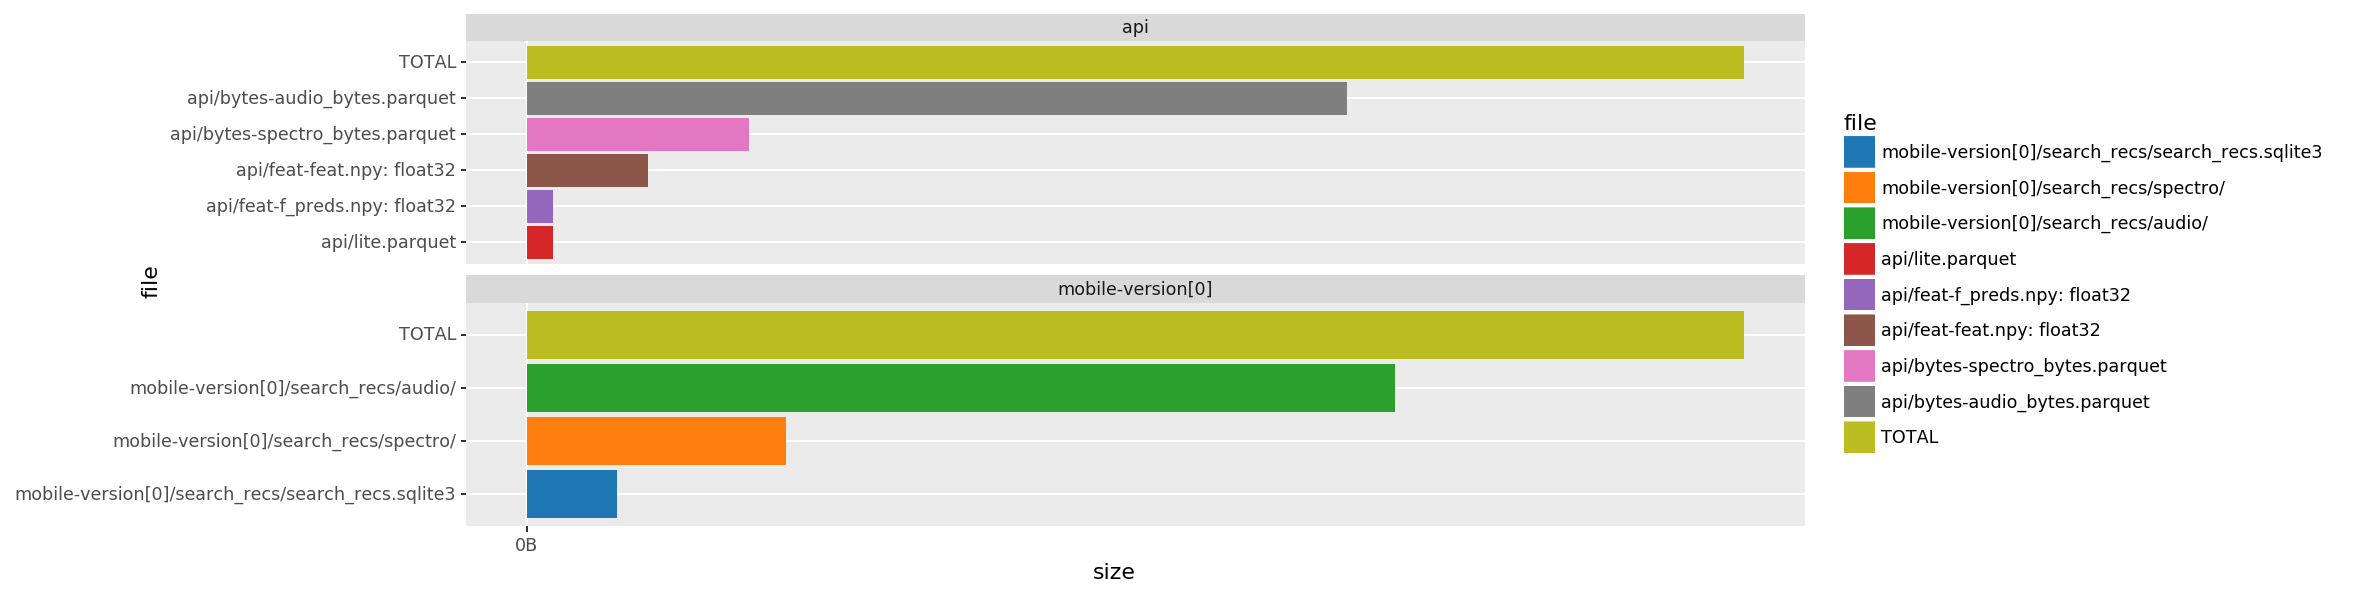

<ggplot: (335260452)>

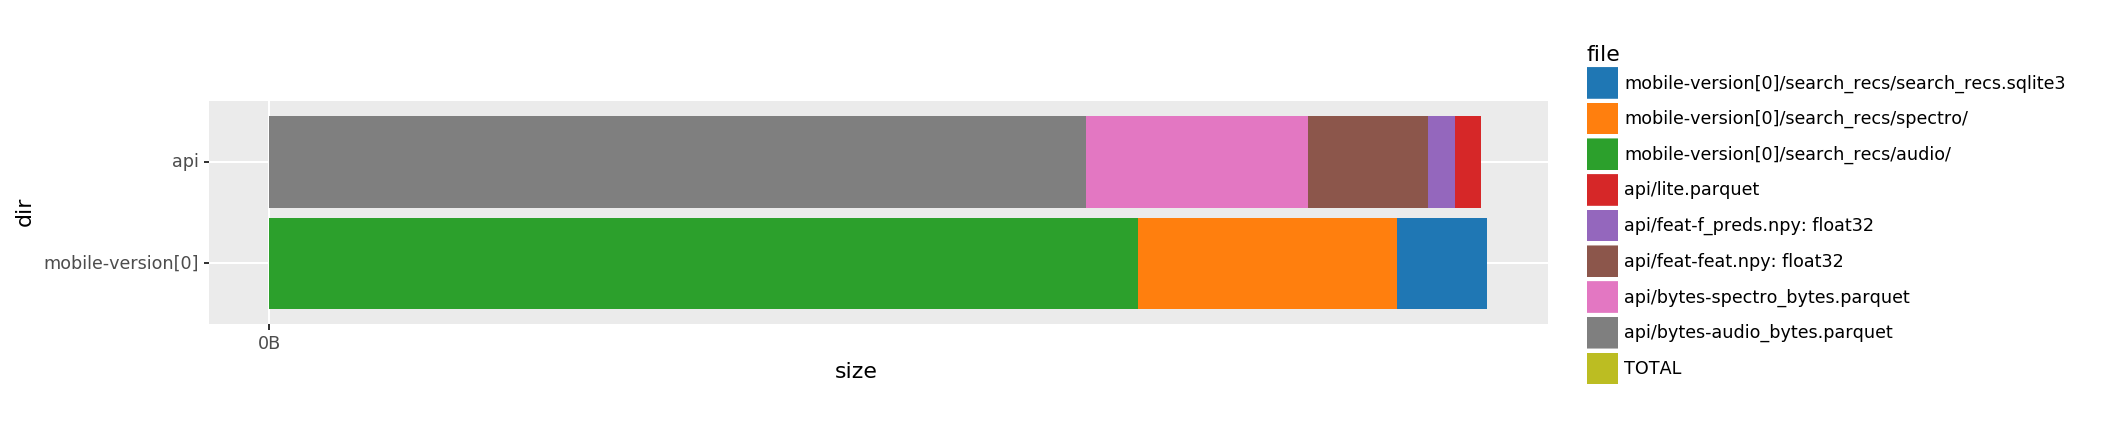

<ggplot: (-9223372036519499944)>

,size,type,0
xc_id,36,int,413174
feat,6104,ndarray,[ 9.259e-02 -3.927e-02 4.972e-01 -4.154e-04 -4.900e-02 -6.117e-02 3.974e-02 -1.629e-01 6.649e-02 -1.643e-02 -8.081e-02 -7.604e-02 -9.098e-02 4.766e-02 -4.830e-02 -6.90...
f_preds,104,ndarray,[3.219e-03 1.693e-03 4.284e-05 3.685e-03 1.657e-03 1.457e-02 9.939e-03 1.444e-03 2.617e-04 6.943e-04 4.435e-04 7.072e-04 2.569e-03 9.745e-03 8.396e-04 2.003e-03 7.801e-04 ...
background,80,list,['White-crowned Sparrow (Zonotrichia leucophrys)']
background_species,80,list,['WCSP']


In [ ]:
log_levels({
    'payloads': 'INFO',
    # 'payloads': 'DEBUG',
})
kwargss = [
    # dict(cache_type='hybrid', refresh=True),  # Simulate cache miss
    dict(cache_type='hybrid'),                # Simulate cache hit
]
search_recss = []
for i, kwargs in enumerate(kwargss):
    if i > 0: print()
    print(f'search_recs(**{kwargs})')
    get_search_recs.cache_clear()
    search_recs = get_search_recs(**kwargs,
        write_mobile_payload=True,
        plot_sizes=True,
    )
    search_recss.append(search_recs)
    display(search_recs
        [['xc_id', 'feat', 'f_preds', 'background', 'background_species']]
        [2:3].reset_index(drop=True).T
        .pipe(df_assign_first,
            size=lambda df: df.T.memory_usage(deep=True),
            type=lambda df: df[0].map(lambda x: type(x).__name__),
        )
    )

In [ ]:
# TODO Turn this into unit tests
#   - Should roundtrip, should preserve category dtypes, should fail if index present
assert len(search_recss) == 2, "Test requires both 'cache hit' + 'cache miss' to be uncommented (above)"
[a, b] = search_recss
pd.testing.assert_frame_equal(a, b, check_column_type=True,
    check_index_type=False,  # Allow Int64Index vs. RangeIndex
)

[skip]